In [5]:
import Su22
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
from qiskit import pulse              
from qiskit.circuit import Parameter 
from IPython.display import display
from qiskit import QuantumCircuit
from qiskit.circuit import Gate
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *
# The pulse simulator
from qiskit.providers.aer import PulseSimulator

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel
token = '792003cde0750f1452faa5cb5fe7c57da849e1119983f608e9a359d49cdb396391d6af09eedfb46af0a043a01103ed64da66835d1a318c0013d64ab3ebc1fe61'
qk.IBMQ.save_account(token=token)
qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub='ibm-q-ornl', group='ornl', project='phy147')
backend = provider.get_backend("ibmq_jakarta")


configrc.store_credentials:WARNING:2022-07-11 10:34:20,326: Credentials already present. Set overwrite=True to overwrite.


IBMQAccountError: 'An IBM Quantum Experience account is already in use for the session.'

In [6]:
print(IBMQ.providers())

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>, <AccountProvider for IBMQ(hub='ibm-q-ornl', group='ornl', project='phy147')>]


In [7]:
import pickle

def loadData(inp):
    # for reading also binary mode is important
    dbfile = open(inp, 'rb')     
    db = pickle.load(dbfile)
    dbfile.close()
    return db

data=loadData('FGRAFS_controls/FGRAFS-controls_N-160_zero-endpoints-True.p')
temp = []
for i in data:
    for j in range(int(4)):
        temp.append(i)
print(len(temp), " " , len(data))

0
640   160


Job Status: job has successfully run
1 L:  1.1247136844510006
Job Status: job has successfully run
2 L:  0.6666243187311996
Job Status: job has successfully run
[-2.87061229e-08 -6.12878762e-09  1.36839858e+00 -1.53148400e+00]


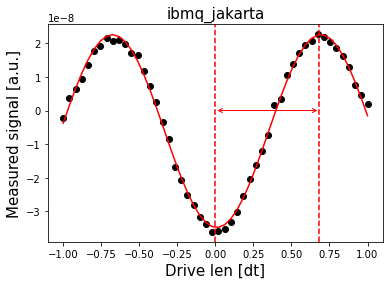

Time taken: 679.8335719108582


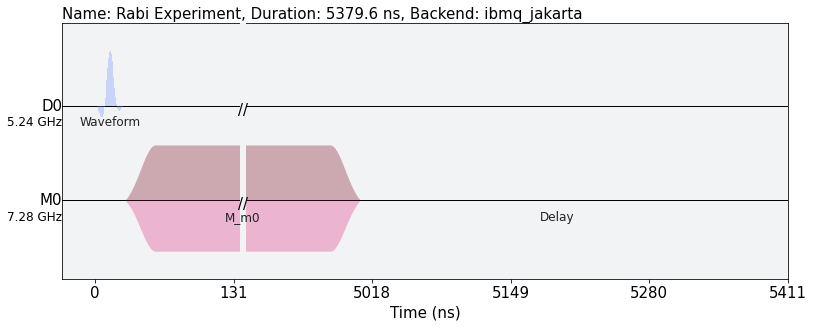

In [4]:
import time

# Generate circuits and run on simulator
t = time.time()
test= [x**2 for x in range(64)]
signal = Su22.Custom_Fgp('low_freq',data,backend)
#print(signal.input)
#print(signal.norm)
print('Time taken:', time.time() - t)
signal.draw()

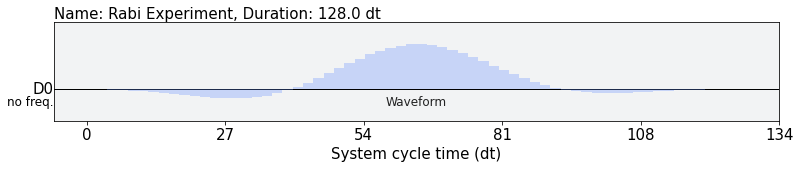

In [131]:
signal.Create_Pulse().draw()

In [5]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    error = np.sqrt(np.diag(pcov))
    return fitparams, y_fit,error

drive_amps_2,rabi_values_2 = signal.Cali(50,signal.length)

Job Status: job has successfully run


In [19]:
pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")
signal.pi_p = pi_amp_2

Pi Amplitude = 1.2041455813680055


## Fidelity Experiment

### Setting Up Circuits

In [8]:
#native X
all_circ = {}
circ = QuantumCircuit(1)
circ.x(0)
all_circ["native"] = circ 

In [9]:
#160dt filter function
data= loadData('FGRAFS_controls/FGRAFS-controls_N-160_zero-endpoints-True.p')
sig_160t =  Su22.Custom_Fgp('160dt ff',data,backend)
circ = QuantumCircuit(1)
circ = sig_160t.add_as_gate(circ,[0])
all_circ["160dt"] = circ

0
Job Status: job has successfully run
1 L:  0.5487510490582149
Job Status: job is queued (21)    

IBMQJobApiError: '"HTTPSConnectionPool(host=\'api-qcon.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q-ornl/Groups/ornl/Projects/phy147/Jobs/62cc35edc99a205f056a1c2a/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x000002542569E6A0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed\'))"'

In [ ]:
data=loadData('FGRAFS_controls_N64.p')
temp = []
for i in data:
    for j in range(int(3)):
        temp.append(i)
print(len(temp), " " , len(data))
sig_64t =  Su22.Custom_Fgp('64->192dt ff',temp,backend)
circ = QuantumCircuit(1)
circ = sig_64t.add_as_gate(circ,[0])
all_circ["64dt"] = circ

### Fidelity

In [ ]:
end_results = {}
for i in all_circ.keys():
    end_results[i]=Su22.State_vec_tomography(all_circ[i],backend)
plot_histogram(end_results)

# New functionality and spectroscopy

### Functions

In [108]:
import numpy as np
import scipy.signal as si
import scipy.linalg as la
import matplotlib.pyplot as plt
import qiskit as qk
from qiskit import Aer

noise_power = 1e-3
num_noise_trajs = 10

def generate_noise_params(s_pow, w0):
    a = [1]
    NN = 512
    BW = 0.005 # changes narrowness of noise spectrum
    b = si.firwin(NN, BW)*np.cos(w0*np.pi*np.arange(NN))
    b = b/la.norm(b)*np.sqrt(s_pow)
    return a, b

def parametrize_circ(circ):
    x = qk.circuit.ParameterVector('x', length=1)
    temp = circ.copy()
    temp.rz(x[0],0)
    temp.measure(0,0)
    return temp,x

def schwarma_trajectories(a, b, num_gates, num_trajectories):
    # a: coefficients of linear filter numerator
    # b: coefficients of linear filter demoninator
    # num_gates: number of gates in circuit to be "schwarmafied"
    # num_trajectories: number of noise trajectories required
    traj_list = []
    for _ in range(num_trajectories):
        angles = si.lfilter(b, a, np.random.randn(num_gates + 1000))[1000:]
        traj_list.append(angles)
    return traj_list
shots=5000
def Spec(circ,start,end,num_center_freqs=100,backend =backend_sim):  
    num_gates=1
    noisy_exp,param_vec = parametrize_circ(circ)
    circ_batch = []
    center_idxs=[]
    centers=[]
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
        #print('Probing Filter Function at Normalized Frequency: ', center)
        # Generate noise trajectories
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = schwarma_trajectories(a, b, num_gates, num_noise_trajs)
    
        # Build noisy circuit dictionary
        for traj in noise_traj_list:
            bound_params = {param_vec: traj}
            bound_circ = noisy_exp.bind_parameters(bound_params)
            circ_batch.append(bound_circ)

        # Run circuits
    job = qk.execute(circ_batch, backend=backend, optimization_level=0, shots=shots)
    results = job.result()

    # Compile Results
    prob = 0
    counter = 0
    for i in range(int(len(circ_batch)/num_noise_trajs)):
        for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)-1]:
            zero_counts = results.get_counts(circ).get('1',0)
            prob += zero_counts/shots
        prob = prob/num_noise_trajs
        all_probs[center_idxs[counter], :] = centers[counter], prob
        counter+=1
        prob=0
    return all_probs, circ_batch

In [113]:
num_noise_trajs_2 = 30
def Spec_2(circ,start,end,num_center_freqs=100,backend =backend_sim):  
    num_gates=1
    noisy_exp,param_vec = parametrize_circ(circ)
    all_probs = np.zeros([num_center_freqs, 2])
    for center_idx, center in enumerate(np.linspace(start, end, num_center_freqs)): # vary noise center frequency
        a, b = generate_noise_params(noise_power, center)
        noise_traj_list = schwarma_trajectories(a, b, num_gates, num_noise_trajs_2)
        # Build noisy circuit dictionary
        circ_batch = []
        for traj in noise_traj_list:
            bound_circ = noisy_exp.bind_parameters({param_vec: traj})
            circ_batch.append(bound_circ)

        # Run circuits
        job = qk.execute(circ_batch, backend=backend, optimization_level=0, shots=shots)
        results = job.result()

        # Compile Results
        prob = 0
        for circ in circ_batch:
            zero_counts = results.get_counts(circ).get('1',0)
            prob += zero_counts/shots
        prob = prob/num_noise_trajs_2

        all_probs[center_idx, :] = center, prob
    return all_probs, circ_batch

In [81]:
armonk_model = PulseSystemModel.from_backend(backend)
backend_sim = PulseSimulator(system_model=armonk_model)

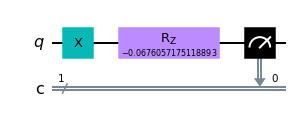

In [114]:
circ = QuantumCircuit(1,1)
circ.x(0)
#circ = signal.add_as_gate(circ,[0])
all_p, batch_circ = Spec_2(circ,0.02,0.98,100,backend = signal.backend)
batch_circ[2].draw('mpl')

Text(0.5, 0, 'Center Frequency')

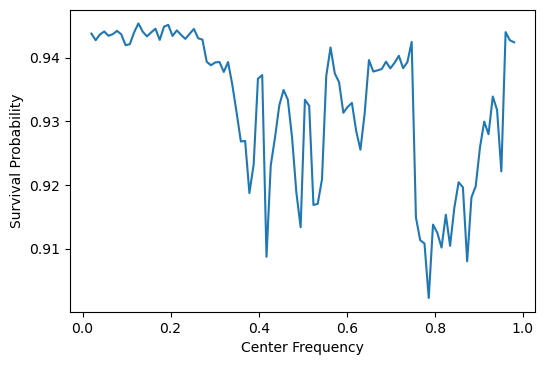

In [117]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

### Spectroscopy Comparisions

Time taken: 9858.253046274185


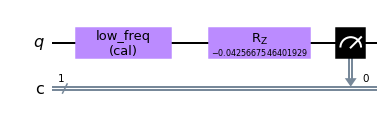

In [122]:
circ = QuantumCircuit(1,1)
#circ.x(0)
circ = signal.add_as_gate(circ,[0])
t = time.time()
all_p_2, batch_circ_2 = Spec_2(circ,0.02,0.98,100,backend=signal.backend)
print('Time taken:', time.time() - t)
batch_circ_2[2].draw('mpl')

Text(0.5, 0, 'Center Frequency')

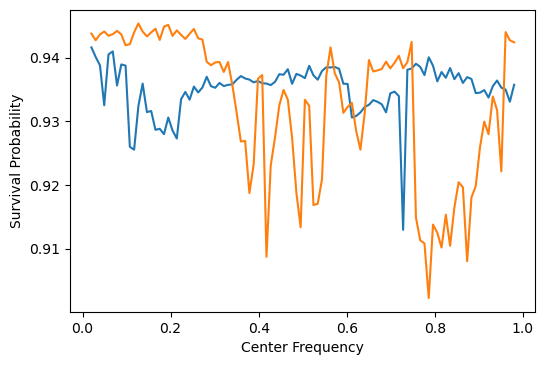

In [124]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p_2[:,0], 1-all_p_2[:,1])
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

In [130]:
with open('Xgate.p', 'wb') as handle:
    pickle.dump(all_p, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('Filter.p', 'wb') as handle:
    pickle.dump(all_p_2, handle, protocol=pickle.HIGHEST_PROTOCOL)

Job Status: job has successfully run
1 L:  0.5476627778484164
Job Status: job has successfully run
[-2.70729118e-08 -1.72440122e-09  1.08694999e+00 -1.52465062e+00]


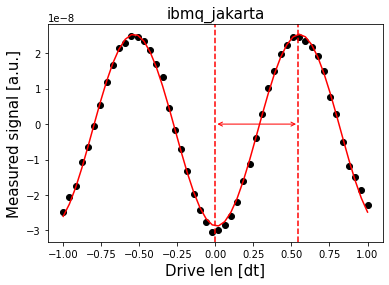

In [134]:
signal_3 =  Su22.Custom_Fgp('high_freq',data,backend)

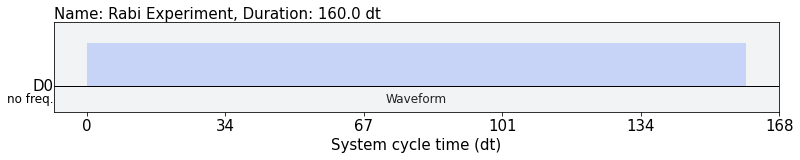

In [135]:
signal2.Create_Pulse().draw()

Time taken: 11756.217401266098


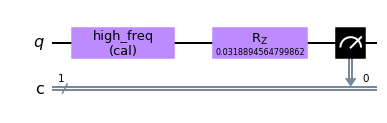

In [136]:
circ_2 = QuantumCircuit(1,1)
circ_2 = signal_3.add_as_gate(circ_2,[0])
t = time.time()
all_p_3, batch_circ_3 = Spec_2(circ_2,0.02,0.98,100,backend=signal.backend)
print('Time taken:', time.time() - t)
batch_circ_3[2].draw('mpl')

Text(0.5, 0, 'Center Frequency')

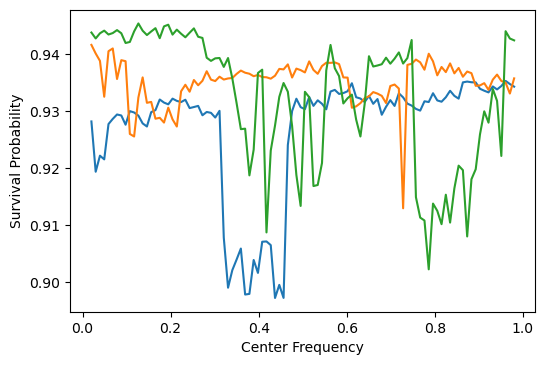

In [137]:
fig = plt.figure(dpi=100)
ax = fig.add_subplot(111)
ax.plot(all_p_3[:,0], 1-all_p_3[:,1])
ax.plot(all_p_2[:,0], 1-all_p_2[:,1])
ax.plot(all_p[:,0], 1-all_p[:,1])
ax.set_ylabel('Survival Probability')
ax.set_xlabel('Center Frequency')

# Job retrevial and Checking

In [111]:
job= backend.retrieve_job('62ca2ae97f0655a83b8a40ed')
results = job.result()
prob = 0
counter = 0
num_center_freqs=30
center_idxs=[]
centers=[]
all_probs = np.zeros([num_center_freqs, 2])
circ_batch = np.zeros(300)
for center_idx, center in enumerate(np.linspace(0.02, 0.98,30, num_center_freqs)): # vary noise center frequency
        center_idxs.append(center_idx)
        centers.append(center)
cc=0
for i in range(int(len(circ_batch)/num_noise_trajs)):
    for circ in circ_batch[i*num_noise_trajs:((i+1)*num_noise_trajs)-1]:
        zero_counts = results.get_counts(cc).get('1')
        prob += zero_counts/shots
        cc+=1
    prob = prob/num_noise_trajs
    all_probs[center_idxs[counter], :] = centers[counter], prob
    counter+=1
    prob=0